In [11]:
from dasly import das_filter, das_loader, das_plotter, dasly, das_sampler, helper
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib import colors
import pandas as pd

from dasly.simpledas import simpleDASreader

In [2]:
from dasly import dasly
from dasly.das_loader import DASLoader
from dasly.das_filter import DASFilter
from dasly.das_plotter import DASPlotter
from dasly.das_sampler import DASSampler
from dasly.das_analyzer import DASAnalyzer

In [2]:
das = dasly.Dasly()
das.load_data(
    # folder_path='/media/kptruong/yellow02/Aastfjordbrua/Aastfjordbrua/',
    folder_path='/media/kptruong/yellow02/Aastfjordbrua/',
    # start='20231005 094345',
    # start='20230901 103015',  # full 2 lines
    # start='20231005 082445',
    # start='20230901 163110',  # part of a line
    # start='20231005 082445',
    # start='20230901 183015',  # noise
    start='20230901 104015',  # 2 cars close to each other
    duration=60,
    integrate=False
)


7 files, from 104014 to 104114


In [3]:
das.file_paths

['/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104014.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104024.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104034.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104044.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104054.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104104.hdf5',
 '/media/kptruong/yellow02/Aastfjordbrua/20230901/dphi/104114.hdf5']

vmin: -8.4e-06, vmax: 8.4e-06


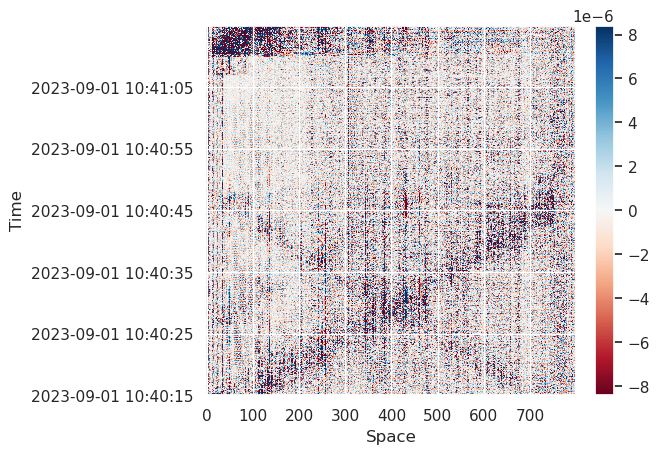

In [4]:
das.heatmap()

Signal updated with low-pass filter.
Signal updated with new temporal sampling rate 8.
Signal updated with Gaussian smoothing.
Signal updated with Sobel filter.
Signal updated with binary transform with threshold 2.6e-08.


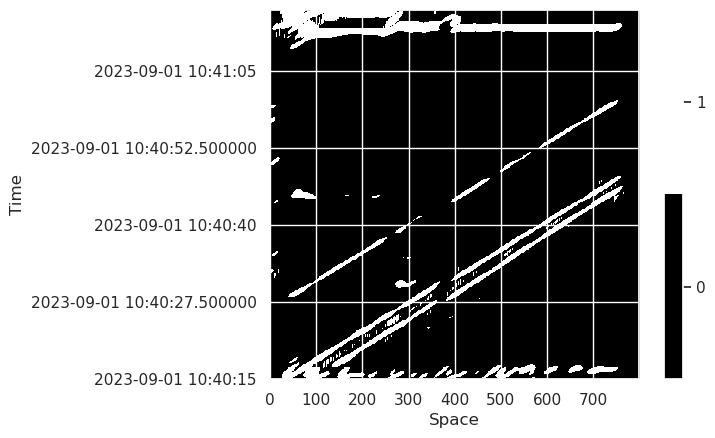

In [5]:
das.reset()
das.lowpass_filter(0.5)
das.decimate(t_rate=6)
das.gaussian_smooth(85, 90, std_s=10)
# das.gaussian_smooth(-90, -85, std_s=10)
das.sobel_filter()
das.binary_transform(threshold=2.6e-08)  # 2.61e-08
das.heatmap()

17 lines are detected.


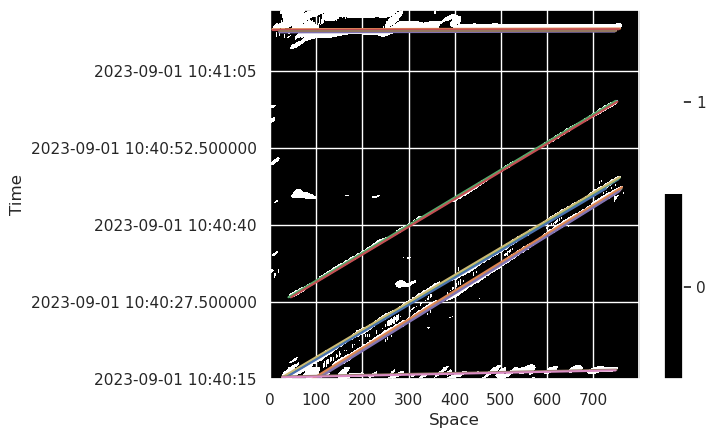

In [6]:
das.hough_transform(target_speed=90, speed_res=0.5, length_meters=600, threshold_percent=0.6, max_line_gap_percent=0.2)
das.heatmap()

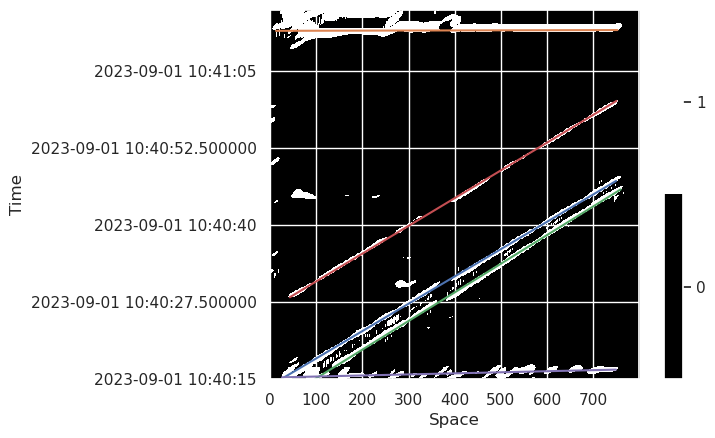

In [7]:
das.dbscan(eps_seconds=1)
das.heatmap()

In [10]:
das.lines_df['t1_edge'].to_numpy()

array(['2023-09-01T10:40:15.000000000', '2023-09-01T10:41:11.497801083',
       '2023-09-01T10:40:15.000000000', '2023-09-01T10:40:26.311350778',
       '2023-09-01T10:40:15.205048409'], dtype='datetime64[ns]')

vmax: 0.00836


(17, 41)


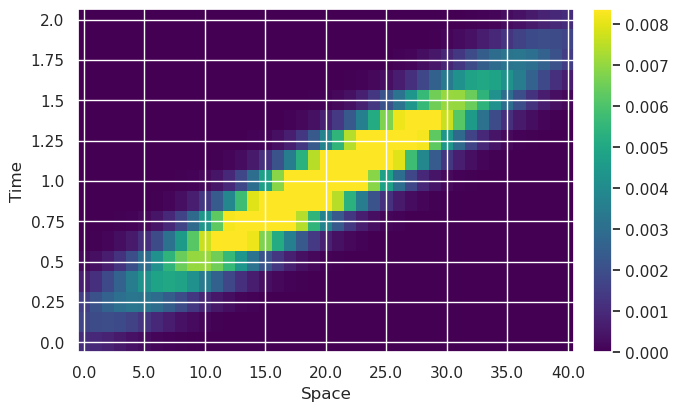

In [ ]:
print(das.gauss_kernel.shape)
das.heatmap(
    das.gauss_kernel,
    aspect=das.signal.shape[1]/das.signal.shape[0]
)

In [32]:
a = das.lines
b = das.lines[0:3] + das.lines[0:3]

In [33]:
b

array([[  56,    2, 1498,  514],
       [  26,  904, 1504,  906],
       [ 196,    0, 1518,  492]])

In [34]:
a_expanded = a[:, np.newaxis, :]  # Shape: (N, 1, K)
b_expanded = b[np.newaxis, :, :]  # Shape: (1, M, K)


distance_matrix = das._metric(a_expanded, b_expanded)
distance_matrix

array([[258.75, 577.25, 293.25],
       [325.  , 417.5 , 360.  ],
       [262.75, 595.25, 275.75],
       [254.5 , 528.5 , 289.5 ],
       [320.25, 637.75, 355.25]])

In [28]:
a

array([[ 28,   1, 749, 257],
       [ 13, 452, 752, 453],
       [ 98,   0, 759, 246],
       [ 43, 106, 750, 361],
       [ 26,   2, 749,  12]])

In [2]:
das.lines_df

NameError: name 'das' is not defined

In [ ]:
# Define the vectorized custom distance function
def _metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Calculate the distance between lines in spatial-temporal data.
    It is the average distance by seconds or average distance by meters.
    """
    # Replace the arbitrary number max int32 with nan
    arb_num = np.iinfo(np.int32).max
    x = np.where(x == arb_num, np.nan, x)
    y = np.where(y == arb_num, np.nan, y)

    # Calculate absolute distance and handle NaNs
    abs_dist = np.abs(x - y)
    sum_dist = np.nansum(abs_dist, axis=-1)  # Sum of non-nan values along the last axis
    count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)  # Count of non-nan values along the last axis
    
    # Calculate mean distance
    mean_dist = np.where(count_non_nan > 0, sum_dist / count_non_nan, arb_num)
    
    return mean_dist

In [36]:
_metric(a_expanded, b_expanded)

array([[258.75, 577.25, 293.25],
       [325.  , 417.5 , 360.  ],
       [262.75, 595.25, 275.75],
       [254.5 , 528.5 , 289.5 ],
       [320.25, 637.75, 355.25]])

In [1]:
import numpy as np

# Example arrays
a = np.array(['a', 'b', 'c', 'd'])  # 4 points names
b = np.array(['m', 'n', 'o'])       # 3 points names

# Example distance matrix between points in a and b (4x3)
dist_matrix = np.array([
    [0.5, 2.0, 3.5],
    [1.5, 0.4, 2.8],
    [2.1, 1.1, 1.3],
    [3.6, 2.2, 2.0]
])

# Define a threshold
threshold = 1.0

# Find the indices of the minimum distances
min_indices = np.argmin(dist_matrix, axis=0)

# Find the minimum distances for each point in b
min_distances = np.min(dist_matrix, axis=0)

# Vectorized renaming based on the threshold
# Create a mask for distances below the threshold
mask = min_distances < threshold

# Create an array to hold the new names
renamed_b = np.where(mask, a[min_indices], b)

print("Original names in b:", b)
print("Renamed names in b:", renamed_b)

Original names in b: ['m' 'n' 'o']
Renamed names in b: ['a' 'b' 'o']


In [45]:
a[min_indices]

array(['a', 'b', 'c'], dtype='<U1')

In [ ]:
das._y_vals_lines(das.lines, x_coords=np.arange(das.signal.shape[1])).shape

(5, 800)

In [35]:
import numpy as np

def _metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Calculate the distance between 2 lines in a spatial-temporal data.
    It is the average distance by seconds or average distance by meters.
    """
    # Replace the arbitrary number max int32 with nan
    arb_num = np.iinfo(np.int32).max
    x = np.where(x == arb_num, np.nan, x)
    y = np.where(y == arb_num, np.nan, y)

    abs_dist = np.abs(x - y)
    sum_dist = np.nansum(abs_dist, axis=-1)  # Sum of non-nan values
    count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)
    mean_dist = np.where(count_non_nan > 0, sum_dist / count_non_nan, arb_num)
    
    return mean_dist

# Example arrays
N, K = 5, 3  # Example dimensions
M = 4

# Randomly generating arrays for demonstration
a = np.random.rand(N, K) * 10
b = np.random.rand(M, K) * 10

# Expand dimensions to enable broadcasting
a_exp = a[:, np.newaxis, :]  # Shape: (N, 1, K)
b_exp = b[np.newaxis, :, :]  # Shape: (1, M, K)

# Calculate pairwise distances using broadcasting
dist_matrix = _metric(a_exp, b_exp)
print("Distance Matrix:\n", dist_matrix)

# Define a threshold
threshold = 5.0

# Find the indices where the distance is less than the threshold
indices = np.where(dist_matrix < threshold)

# Merge points from b to a based on the threshold condition
merged_a = np.copy(a)
for idx in range(len(indices[0])):
    i = indices[0][idx]
    j = indices[1][idx]
    merged_a[i] = (a[i] + b[j]) / 2  # Example merge logic: average the coordinates

print("Merged Points:\n", merged_a)

Distance Matrix:
 [[2.66142633 1.65762569 3.55778395 2.0107344 ]
 [4.04008476 2.2321907  4.93644239 4.37426031]
 [4.02035463 4.45531529 2.88605129 5.08469118]
 [2.09565261 3.09878296 2.81663531 2.52476091]
 [1.87154504 3.24208008 3.34108956 4.14514208]]
Merged Points:
 [[7.29748871 2.00163009 3.90030259]
 [6.5588381  3.04006695 5.668504  ]
 [2.84033069 3.95690735 0.70154354]
 [6.41664011 0.40263796 5.26842037]
 [5.0882097  3.08010701 3.81415819]]


# push into PostGreSQL

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import uuid

In [ ]:
das.lines_df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,80.220690,22.283525,727.0,32.625,31.0,2023-09-01 10:40:15.000,758.0,2023-09-01 10:40:47.625,31.000000,2023-09-01 10:40:15.000000000,...,31.0,0.0,758.0,261.0,31.000000,0.000000,799.0,275.719395,-11.129298,275.719395
1,1644.480000,456.800000,571.0,1.250,93.0,2023-09-01 10:41:11.125,664.0,2023-09-01 10:41:12.375,0.000000,2023-09-01 10:41:10.921409807,...,93.0,449.0,664.0,459.0,0.000000,447.371278,799.0,461.364273,447.371278,461.364273
2,77.305263,21.473684,663.0,30.875,97.0,2023-09-01 10:40:15.125,760.0,2023-09-01 10:40:46.000,94.315789,2023-09-01 10:40:15.000000000,...,97.0,1.0,760.0,248.0,94.315789,0.000000,799.0,262.529412,-35.137255,262.529412
3,81.351394,22.597610,709.0,31.375,42.0,2023-09-01 10:40:28.500,751.0,2023-09-01 10:40:59.875,0.000000,2023-09-01 10:40:26.641396333,...,42.0,108.0,751.0,359.0,0.000000,93.131171,799.0,375.992948,93.131171,375.992948
4,2316.800000,643.555556,724.0,1.125,27.0,2023-09-01 10:40:15.375,751.0,2023-09-01 10:40:16.500,0.000000,2023-09-01 10:40:15.333045580,...,27.0,3.0,751.0,12.0,0.000000,2.664365,799.0,12.596685,2.664365,12.596685


In [ ]:
das.lines_df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,80.220690,22.283525,727.0,32.625,31.0,2023-09-01 10:40:15.000,758.0,2023-09-01 10:40:47.625,31.000000,2023-09-01 10:40:15.000000000,...,31.0,0.0,758.0,261.0,31.000000,0.000000,799.0,275.719395,-11.129298,275.719395
1,1644.480000,456.800000,571.0,1.250,93.0,2023-09-01 10:41:11.125,664.0,2023-09-01 10:41:12.375,0.000000,2023-09-01 10:41:10.921409807,...,93.0,449.0,664.0,459.0,0.000000,447.371278,799.0,461.364273,447.371278,461.364273
2,77.305263,21.473684,663.0,30.875,97.0,2023-09-01 10:40:15.125,760.0,2023-09-01 10:40:46.000,94.315789,2023-09-01 10:40:15.000000000,...,97.0,1.0,760.0,248.0,94.315789,0.000000,799.0,262.529412,-35.137255,262.529412
3,81.351394,22.597610,709.0,31.375,42.0,2023-09-01 10:40:28.500,751.0,2023-09-01 10:40:59.875,0.000000,2023-09-01 10:40:26.641396333,...,42.0,108.0,751.0,359.0,0.000000,93.131171,799.0,375.992948,93.131171,375.992948
4,2316.800000,643.555556,724.0,1.125,27.0,2023-09-01 10:40:15.375,751.0,2023-09-01 10:40:16.500,0.000000,2023-09-01 10:40:15.333045580,...,27.0,3.0,751.0,12.0,0.000000,2.664365,799.0,12.596685,2.664365,12.596685


In [ ]:
# Define your PostgreSQL credentials
username = 'kptruong'
password = 'cgf123rock'
# host = 'localhost'
host = '129.241.154.236'
port = '5432'
database = 'aastfjordbrua'

# Create a connection string
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'

# Create an engine
engine = create_engine(connection_string)



In [ ]:
# Append DataFrame to table in PostgreSQL
table_name = 'test_table1'
das.lines_df.to_sql(table_name, engine, if_exists='append', index=False)

5

In [ ]:
# Execute a SQL query
query = 'SELECT * FROM test_table'
df = pd.read_sql(query, engine)
df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,80.220690,22.283525,727.0,32.625,31.0,2023-09-01 10:40:15.000,758.0,2023-09-01 10:40:47.625,31.000000,2023-09-01 10:40:15.000000,...,31.0,0.0,758.0,261.0,31.000000,0.000000,799.0,275.719395,-11.129298,275.719395
1,1644.480000,456.800000,571.0,1.250,93.0,2023-09-01 10:41:11.125,664.0,2023-09-01 10:41:12.375,0.000000,2023-09-01 10:41:10.921409,...,93.0,449.0,664.0,459.0,0.000000,447.371278,799.0,461.364273,447.371278,461.364273
2,77.305263,21.473684,663.0,30.875,97.0,2023-09-01 10:40:15.125,760.0,2023-09-01 10:40:46.000,94.315789,2023-09-01 10:40:15.000000,...,97.0,1.0,760.0,248.0,94.315789,0.000000,799.0,262.529412,-35.137255,262.529412
3,81.351394,22.597610,709.0,31.375,42.0,2023-09-01 10:40:28.500,751.0,2023-09-01 10:40:59.875,0.000000,2023-09-01 10:40:26.641396,...,42.0,108.0,751.0,359.0,0.000000,93.131171,799.0,375.992948,93.131171,375.992948
4,2316.800000,643.555556,724.0,1.125,27.0,2023-09-01 10:40:15.375,751.0,2023-09-01 10:40:16.500,0.000000,2023-09-01 10:40:15.333045,...,27.0,3.0,751.0,12.0,0.000000,2.664365,799.0,12.596685,2.664365,12.596685


In [ ]:
# Create a sample ndarray with shape (N, 4)
array = np.array([[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10, 11, 12]])

In [ ]:
array

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
scalar = 10
array[:, [1, 3]] += scalar
array

array([[ 1, 12,  3, 14],
       [ 5, 16,  7, 18],
       [ 9, 20, 11, 22]])

In [ ]:
mask = das.lines_df['speed_kmh'].to_numpy() > 80
mask

array([ True,  True, False,  True,  True])

In [ ]:
das.lines_df[mask]

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,80.220690,22.283525,727.0,32.625,31.0,2023-09-01 10:40:15.000,758.0,2023-09-01 10:40:47.625,31.0,2023-09-01 10:40:15.000000000,...,31.0,0.0,758.0,261.0,31.0,0.000000,799.0,275.719395,-11.129298,275.719395
1,1644.480000,456.800000,571.0,1.250,93.0,2023-09-01 10:41:11.125,664.0,2023-09-01 10:41:12.375,0.0,2023-09-01 10:41:10.921409807,...,93.0,449.0,664.0,459.0,0.0,447.371278,799.0,461.364273,447.371278,461.364273
3,81.351394,22.597610,709.0,31.375,42.0,2023-09-01 10:40:28.500,751.0,2023-09-01 10:40:59.875,0.0,2023-09-01 10:40:26.641396333,...,42.0,108.0,751.0,359.0,0.0,93.131171,799.0,375.992948,93.131171,375.992948
4,2316.800000,643.555556,724.0,1.125,27.0,2023-09-01 10:40:15.375,751.0,2023-09-01 10:40:16.500,0.0,2023-09-01 10:40:15.333045580,...,27.0,3.0,751.0,12.0,0.0,2.664365,799.0,12.596685,2.664365,12.596685


In [ ]:
das.lines[mask]

array([[ 31,   0, 758, 261],
       [ 93, 449, 664, 459],
       [ 42, 108, 751, 359],
       [ 27,   3, 751,  12]])

In [ ]:
das.lines

array([[ 31,   0, 758, 261],
       [ 93, 449, 664, 459],
       [ 97,   1, 760, 248],
       [ 42, 108, 751, 359],
       [ 27,   3, 751,  12]])

In [ ]:
import numpy as np

# Create sample arrays with shapes (N, 4) and (M, 4)
a = np.empty((0, 4))

b = np.array([[13, 14, 15, 16],
              [17, 18, 19, 20]])

# Concatenate the arrays along the first axis (rows)
result = np.concatenate((a, b), axis=0)

# Print the concatenated array
print(result)

[[13. 14. 15. 16.]
 [17. 18. 19. 20.]]


In [ ]:
np.empty((0, 4))

array([], shape=(0, 4), dtype=float64)

In [ ]:
import pandas as pd
import re

def filepath_to_timestamp(filepath):
    # Define the regex pattern to extract date and time
    pattern = r'/(\d{8})/dphi/(\d{6})\.hdf5$'
    
    # Search for the pattern in the filepath
    match = re.search(pattern, filepath)
    
    if match:
        # Extract the date and time components
        date_str = match.group(1)
        time_str = match.group(2)
        
        # Convert to a pandas Timestamp
        timestamp = pd.Timestamp(f'{date_str} {time_str}')
        return timestamp
    else:
        raise ValueError("Filepath does not match the expected pattern: /YYYYMMDD/dphi/HHMMSS.hdf5")

# Example usage
filepath = '/some/path/20230711/dphi/123456.hdf5'
timestamp = filepath_to_timestamp(filepath)
print(timestamp)

2023-07-11 12:34:56


In [ ]:
das.signal.index[1]

'2023-09-01 10:40:15'

In [ ]:
previous = np.array(['a', 'b', 'c', 'd', 'e']) 
new = np.array(['l', 'm', 'n', 'o']) 
cluster = np.array([0, 1, 2, 3, 4, -1, 2, -1, 5])
cluster = das._replace_neg_ones(cluster)
cluster

array([0, 1, 2, 3, 4, 6, 2, 7, 5])